# 2. Regression with XGBoost

These are my personal notes of the Datacamp course [Extreme Gradient Boosting with XGBoost](https://app.datacamp.com/learn/courses/extreme-gradient-boosting-with-xgboost).

The course has 4 main sections:

1. Classification
2. **Regression**: the current notebook.
3. Fine-tuning XGBoost
4. Using XGBoost in Pipelines

XGBoost is an implementation of the [Gradient Boosting](https://en.wikipedia.org/wiki/Gradient_boosting) algorithm in C++ which has bindings to other languages, such as Python. It has the following properties:

- Fast.
- Best performance.
- Parallelizable, on a computer and across the network. So it can work with huge datasets distributed on several nodes/GPUs.
- We can use it for classification and regression.
- The [Python API](https://xgboost.readthedocs.io/en/stable/python/python_api.html) is easy to use and has two major flavors or sub-APIs:
  - The **Scikit-Learn API**: We instantiate `XGBRegressor()` or `XGBClassifier` and then we can `fit()` and `predict()`, using the typical Scikit-Learn parameters; we can even use those objects with other Scikit-Learn modules, such as `GridSearchCV`.
  - The **Learning API**: The native XGBoost Python API requires to convert the dataframes into `DMatrix` objects first; then, we have powerful methods which allow for tuning many parameters: `xgb.cv()`, `xgb.train()`. The native/learning API is very easy to use. **Note: the parameter names are different compared to the Scikit-Learn API!**

Classification is the original supervised learning problem addressed by XGBoost, although it can also handle regression problems.

### Installation

```python
# PIP
pip install xgboost

# Conda: General
conda install -c conda-forge py-xgboost

# Conda: CPU only
conda install -c conda-forge py-xgboost-cpu

# Conda: Use NVIDIA GPU: Linux x86_64
conda install -c conda-forge py-xgboost-gpu

# For tree visualization
pip install graphviz
```

### Table of Contents

- [2.1 Non-Linear and Linear Weak Learners: Ames/Boston Housing Prediction](#2.1-Non-Linear-and-Linear-Weak-Learners:-Ames/Boston-Housing-Prediction)
- [2.2 Regression with Cross-Validation](#2.2-Regression-with-Cross-Validation)
- [2.3 Regression with Regularization](#2.3-Regression-with-Regularization)
- [2.4 Visualizing Trees](#2.4-Visualizing-Trees)
- [2.5 Feature Importances](#2.5-Feature-Importances)

## 2.1 Non-Linear and Linear Weak Learners: Ames/Boston Housing Prediction

In regression, continuous values are predicted.

Typical metrics for regression:

- Root mean square error (RMSE): `sqrt(sum((y_true-y_pred)^2))`: `"rmse"`.
- Mean absolute error (MAE): `mean(abs(y_true-y_pred))`: `"mae".`

The objective function in regression is `reg:linear` (deprecated) or `reg:squarederror`.

We can use as base learners two types of models:

- Trees, i.e., CARTs: `params["booster"] = "gbtree"`. **These are the learners by default, and are almost the unique ones that are used in practice.**
- Linear learners, i.e., linear models: : `params["booster"] = "gblinear"`.

The ensemble model is a weighted sum of the weak learners; if we use the linear learners, the final model is linear, if use trees as weak learners, the final model is non-linear.

Additionally, we can apply **regularization** to control the complexity of the model:

- `gamma`: minimum loss reduction allowed for a split to occur.
- `alpha`: L1 regularization on (leaf) weights, larger values mean more regularization.
- `lambda`: L2 regularization on (leaf) weights.

Apparently, all these regularization parameters can be used with both base/weak learners; however, their interpretation is different in each case:

1. Decision Trees (`"gbtree"` base learner):
  - Gamma: Controls the minimum loss reduction required to make a split in a decision tree. A higher value of gamma makes the algorithm more conservative and reduces the number of splits.
  - Alpha: L1 regularization parameter on leaf weights. A higher value of alpha makes the leaf weights closer to zero, resulting in a more sparse tree.
  - Lambda: L2 regularization parameter on leaf weights. A higher value of lambda makes the leaf weights smaller, resulting in a smoother tree.

2. Linear Models (`"gblinear"` base learner):
  - Gamma: Controls the L1 regularization strength on the weights. A higher value of gamma results in more sparsity in the weight matrix.
  - Alpha: L1 regularization parameter on the bias. A higher value of alpha makes the bias closer to zero, resulting in a more sparse model.
  - Lambda: L2 regularization parameter on the weights. A higher value of lambda makes the weights smaller, resulting in a smoother model.

### 2.1.1 Default Weak Learner (Trees, CART)

In [3]:
import xgboost as xgb
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [4]:
boston_data = pd.read_csv("../data/ames_housing_trimmed_processed.csv")

In [5]:
boston_data.head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,Remodeled,GrLivArea,BsmtFullBath,BsmtHalfBath,...,HouseStyle_1.5Unf,HouseStyle_1Story,HouseStyle_2.5Fin,HouseStyle_2.5Unf,HouseStyle_2Story,HouseStyle_SFoyer,HouseStyle_SLvl,PavedDrive_P,PavedDrive_Y,SalePrice
0,60,65.0,8450,7,5,2003,0,1710,1,0,...,0,0,0,0,1,0,0,0,1,208500
1,20,80.0,9600,6,8,1976,0,1262,0,1,...,0,1,0,0,0,0,0,0,1,181500
2,60,68.0,11250,7,5,2001,1,1786,1,0,...,0,0,0,0,1,0,0,0,1,223500
3,70,60.0,9550,7,5,1915,1,1717,1,0,...,0,0,0,0,1,0,0,0,1,140000
4,60,84.0,14260,8,5,2000,0,2198,1,0,...,0,0,0,0,1,0,0,0,1,250000


In [6]:
boston_data.shape

(1460, 57)

In [7]:
X, y = boston_data.iloc[:,:-1],boston_data.iloc[:,-1]
X_train, X_test, y_train, y_test= train_test_split(X,
                                                   y,
                                                   test_size=0.2,
                                                   random_state=123)

In [8]:
xg_reg = xgb.XGBRegressor(objective='reg:squarederror', # reg:linear
                          n_estimators=10,
                          seed=123)

In [9]:
xg_reg.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.300000012,
             max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=10, n_jobs=8,
             num_parallel_tree=1, predictor='auto', random_state=123,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=123,
             subsample=1, tree_method='exact', validate_parameters=1,
             verbosity=None)

In [10]:
preds = xg_reg.predict(X_test)

In [11]:
rmse = np.sqrt(mean_squared_error(y_test,preds))
print("RMSE: %f" % (rmse))

RMSE: 28106.463641


### 2.1.2 Linear Weak Learner

If we want to use linear weak learners, we need to use the learning API, which is different:

- We need to define `DMatrix` objects.
- We call `xgb.train()`.

In [12]:
import xgboost as xgb
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [13]:
boston_data = pd.read_csv("../data/ames_housing_trimmed_processed.csv")

In [14]:
boston_data.head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,Remodeled,GrLivArea,BsmtFullBath,BsmtHalfBath,...,HouseStyle_1.5Unf,HouseStyle_1Story,HouseStyle_2.5Fin,HouseStyle_2.5Unf,HouseStyle_2Story,HouseStyle_SFoyer,HouseStyle_SLvl,PavedDrive_P,PavedDrive_Y,SalePrice
0,60,65.0,8450,7,5,2003,0,1710,1,0,...,0,0,0,0,1,0,0,0,1,208500
1,20,80.0,9600,6,8,1976,0,1262,0,1,...,0,1,0,0,0,0,0,0,1,181500
2,60,68.0,11250,7,5,2001,1,1786,1,0,...,0,0,0,0,1,0,0,0,1,223500
3,70,60.0,9550,7,5,1915,1,1717,1,0,...,0,0,0,0,1,0,0,0,1,140000
4,60,84.0,14260,8,5,2000,0,2198,1,0,...,0,0,0,0,1,0,0,0,1,250000


In [15]:
X, y = boston_data.iloc[:,:-1],boston_data.iloc[:,-1]
X_train, X_test, y_train, y_test= train_test_split(X,
                                                   y,
                                                   test_size=0.2,
                                                   random_state=123)

In [16]:
# Convert to DMatrix: note that both X and y are in the matrix!
DM_train = xgb.DMatrix(data=X_train,label=y_train)
DM_test =  xgb.DMatrix(data=X_test,label=y_test)

In [17]:
# Define params
# The weak learner is defined with booster
# In this case, we use a linear base learner!
params = {"booster":"gblinear", # Trees are "gbtree", default
          "objective":"reg:squarederror"} # linear
xg_reg = xgb.train(params=params, dtrain=DM_train, num_boost_round=10)

In [18]:
preds = xg_reg.predict(DM_test)

In [19]:
rmse = np.sqrt(mean_squared_error(y_test,preds))
print("RMSE: %f" % (rmse))

RMSE: 41396.164741


## 2.2 Regression with Cross-Validation

As for classification, we need to use the CV API with `DMatrix` objects.

In [27]:
import xgboost as xgb
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [28]:
boston_data = pd.read_csv("../data/ames_housing_trimmed_processed.csv")

In [29]:
X, y = boston_data.iloc[:,:-1],boston_data.iloc[:,-1]

In [30]:
# Create the DMatrix: housing_dmatrix
housing_dmatrix = xgb.DMatrix(data=X, label=y)

In [31]:
# Create the parameter dictionary: params
params = {"objective":"reg:squarederror", "max_depth":4}

In [32]:
# Perform cross-validation: cv_results
cv_results = xgb.cv(dtrain=housing_dmatrix,
                    params=params,
                    nfold=4,
                    num_boost_round=5,
                    metrics="rmse", # or "mae"
                    as_pandas=True,
                    seed=123)

In [35]:
# Print cv_results
print(cv_results)

   train-rmse-mean  train-rmse-std  test-rmse-mean  test-rmse-std
0    141767.531250      429.448328   142980.433594    1193.798509
1    102832.542969      322.473304   104891.396485    1223.159762
2     75872.619140      266.472468    79478.937500    1601.344539
3     57245.650390      273.624608    62411.921875    2220.149857
4     44401.297851      316.422372    51348.280274    2963.377140


In [38]:
# Extract and print final boosting round metric
print((cv_results["test-rmse-mean"]).tail(1))

4    51348.280274
Name: test-rmse-mean, dtype: float64


## 2.3 Regression with Regularization

Recall that we can apply **regularization** to control the complexity of the model:

- `gamma`: minimum loss reduction allowed for a split to occur.
- `alpha`: L1 regularization on (leaf) weights, larger values mean more regularization.
- `lambda`: L2 regularization on (leaf) weights.

Apparently, all these regularization parameters can be used with both base/weak learners; however, their interpretation is different in each case:

1. Decision Trees (`"gbtree"` base learner):
  - Gamma: Controls the minimum loss reduction required to make a split in a decision tree. A higher value of gamma makes the algorithm more conservative and reduces the number of splits.
  - Alpha: L1 regularization parameter on leaf weights. A higher value of alpha makes the leaf weights closer to zero, resulting in a more sparse tree.
  - Lambda: L2 regularization parameter on leaf weights. A higher value of lambda makes the leaf weights smaller, resulting in a smoother tree.

2. Linear Models (`"gblinear"` base learner):
  - Gamma: Controls the L1 regularization strength on the weights. A higher value of gamma results in more sparsity in the weight matrix.
  - Alpha: L1 regularization parameter on the bias. A higher value of alpha makes the bias closer to zero, resulting in a more sparse model.
  - Lambda: L2 regularization parameter on the weights. A higher value of lambda makes the weights smaller, resulting in a smoother model.

In [58]:
import xgboost as xgb
import pandas as pd

In [40]:
boston_data = pd.read_csv("../data/ames_housing_trimmed_processed.csv")
X,y = boston_data.iloc[:,:-1],boston_data.iloc[:,-1]
boston_dmatrix = xgb.DMatrix(data=X,label=y)

In [44]:
params={"objective":"reg:squarederror","max_depth":4}
# L1 regularization values to test
l1_params = [1,10,100]
# Results of each regularization parameter
rmses_l1 = []

In [45]:
# CV with each L1 param
for reg in l1_params:
    # Define L1 regularization param alpha
    params["alpha"] = reg
    # We perform CV
    cv_results = xgb.cv(dtrain=boston_dmatrix,
                        params=params,
                        nfold=4,
                        num_boost_round=10,
                        metrics="rmse",
                        as_pandas=True,
                        seed=123)
    # Store result metric
    rmses_l1.append(cv_results["test-rmse-mean"].tail(1).values[0])

In [46]:
print("Best rmse as a function of l1:")
print(pd.DataFrame(list(zip(l1_params,rmses_l1)), columns=["l1","rmse"]))

Best rmse as a function of l1:
    l1          rmse
0    1  35572.514160
1   10  35571.971680
2  100  35572.370117


## 2.4 Visualizing Trees

If we use the XGBoost learning API (with `DMatrix` and `xgb.train()`) we can visualize the trees under the hood using `plot_tree()`. Note: we need to `pip install graphviz` if not done yet.

In [59]:
import xgboost as xgb
import pandas as pd
import matplotlib.pyplot as plt

In [48]:
boston_data = pd.read_csv("../data/ames_housing_trimmed_processed.csv")
X,y = boston_data.iloc[:,:-1],boston_data.iloc[:,-1]

In [49]:
# Create the DMatrix: housing_dmatrix
housing_dmatrix = xgb.DMatrix(data=X, label=y)

In [52]:
# Create the parameter dictionary: params
params = {"objective":"reg:squarederror", "max_depth":2}

In [53]:
# Train the model: xg_reg
xg_reg = xgb.train(params=params,
                   dtrain=housing_dmatrix,
                   num_boost_round=10) # 10 trees in total

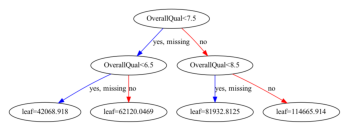

In [61]:
# Plot the first tree
# num_trees refers to the tree, starting with 0
xgb.plot_tree(xg_reg, num_trees=0)
plt.show()

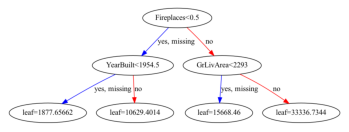

In [62]:
# Plot the fifth tree
xgb.plot_tree(xg_reg, num_trees=4)
plt.show()

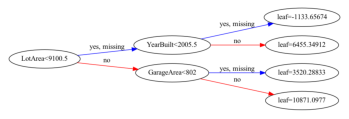

In [64]:
# Plot the last tree sideways
xgb.plot_tree(xg_reg, num_trees=9, rankdir="LR")
plt.show()

## 2.5 Feature Importances

One way of measuring the importance of a feature is counting the number of times each feature is split on across all boosting rounds (trees) in the model. We can visualize the results with `plot_importance()`. For that, we need to use the XGBoost learning API (with `DMatrix` and `xgb.train()`).

In [65]:
import xgboost as xgb
import pandas as pd
import matplotlib.pyplot as plt

In [66]:
boston_data = pd.read_csv("../data/ames_housing_trimmed_processed.csv")
X,y = boston_data.iloc[:,:-1],boston_data.iloc[:,-1]

In [67]:
# Create the DMatrix: housing_dmatrix
housing_dmatrix = xgb.DMatrix(data=X, label=y)

In [69]:
# Create the parameter dictionary: params
params = {"objective":"reg:squarederror", "max_depth":4}

In [70]:
# Train the model: xg_reg
xg_reg = xgb.train(params=params,
                   dtrain=housing_dmatrix,
                   num_boost_round=10) # 10 trees in

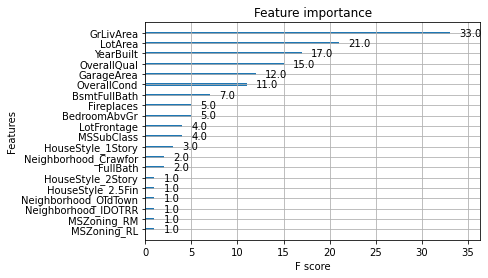

In [71]:
# Plot the feature importances
xgb.plot_importance(xg_reg)
plt.show()